In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

import os
import gc
import random
import tqdm.notebook as tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from PIL import Image
from transformers import ViTForImageClassification, ViTFeatureExtractor
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage import rotate

%matplotlib inline

In [2]:
def set_seed(SEED):
    torch.manual_seed(SEED) 
    torch.cuda.manual_seed_all(SEED) 
    torch.backends.cudnn.deterministic = True 
    torch.backends.cudnn.benchmark = False 
    random.seed(SEED)
    np.random.seed(SEED) 
    os.environ['PYTHONHASHSEED'] = str(SEED)
set_seed(42)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Предварительный анализ данных

In [4]:
DIR_TRAIN = "train/"
DIR_TEST = "test/"

PATH_TRAIN = "train.csv"
PATH_TEST = "test.csv"

In [50]:
df_train = pd.read_csv(PATH_TRAIN)
df_test = pd.read_csv(PATH_TEST)

In [6]:
print("В обучающей выборке {} изображений".format(len(os.listdir(DIR_TRAIN))))
print("В тестовой выборке {} изображений".format(len(os.listdir(DIR_TEST))))

В обучающей выборке 4990 изображений
В тестовой выборке 2138 изображений


In [7]:
df_train.head()

,ID_img,class
0,2138.jpg,4.0
1,2139.jpg,6.0
2,2140.jpg,3.0
3,2141.jpg,6.0
4,2142.jpg,3.0


In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4990 entries, 0 to 4989
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID_img  4990 non-null   object 
 1   class   4990 non-null   float64
dtypes: float64(1), object(1)
memory usage: 78.1+ KB


<AxesSubplot:xlabel='class', ylabel='count'>

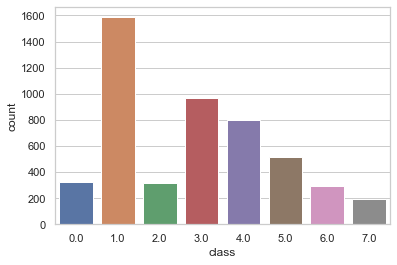

In [9]:
sns.set_theme(style="whitegrid")
sns.countplot(x="class", data=df_train)

In [10]:
class_count = pd.DataFrame()
class_count['count'] = df_train['class'].value_counts().sort_index()
class_count['fraction'] = round(max(class_count['count']) / class_count['count'])
class_count

,count,fraction
0.0,321,5.0
1.0,1586,1.0
2.0,316,5.0
3.0,969,2.0
4.0,797,2.0
5.0,514,3.0
6.0,293,5.0
7.0,194,8.0


In [11]:
model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)
feature_extractor

ViTFeatureExtractor {
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "ViTFeatureExtractor",
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "size": 224
}

## Предобработка данных и создание датасета

In [68]:
class BuildingTechnicsDataset(Dataset):
    def __init__(self, train_df, test_df, feature_extractor):
        """
        Аргументы:
            train_df, test_df (pd.DataFrame): тренировочный и тестовый наборы данных
        """
        self.feature_extractor = feature_extractor
        self.val_df = train_df.sample(frac=0.1, random_state=42)
        self.val_size = len(self.val_df)
        
        self.train_df = train_df.drop(self.val_df.index)
        self.train_size = len(self.train_df)
        
        self.train_df.reset_index(drop=True, inplace=True)
        self.val_df.reset_index(drop=True, inplace=True)
        
        self.test_df = test_df
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val': (self.val_df, self.val_size),
                             'test': (self.test_df, self.test_size)}

        self.set_split('train') 
    
    @classmethod
    def load_dataset(cls, path_train, path_test, dir_train, dir_test, feature_extractor):
        """Загрузка данных датасета
        Аргументы:
            path_train, path_test (str): пути к тренировочному и тестовому наборам данных
            dir_train, dir_test (str): директории с изображениями
        Возвращает:
            экземпляр BuildingTechnicsDataset
        """
        #загрузка данных
        train_df = pd.read_csv(path_train)
        test_df = pd.read_csv(path_test)
        
        #векторизация изображений
        imgs = []
        for img_id in train_df['ID_img']:
            img = Image.open(dir_train + img_id)
            imgs.append(np.asarray(img))
        train_df.insert(len(train_df.columns), 'image', imgs)
        
        imgs = []
        for img_id in test_df['ID_img']:
            img = Image.open(dir_test + img_id)
            imgs.append(np.asarray(img))
        test_df.insert(len(test_df.columns), 'image', imgs)
        
        return cls(train_df[['image', 'class']], test_df[['image']], feature_extractor)
    
    def augmentation(self, img, label):
        img = img.copy()
        if (label == 7) and (random.random() > 0.5):
            shift = 15
            #upper_slice = img[:shift, :].copy()
            img[:-shift, :] = img[shift:, :]
            img[-shift:,:] = np.ones_like(img[:shift, :]) * 255
            
        if (label in (0, 2, 6, 7)) and (random.random() > 0.5):
            img = gaussian_filter(img, sigma=0.7)
        
        if (label in(0, 2, 5, 6)) and (random.random() > 0.7):
            shift = 15
            #left_slice = img[:, :shift].copy()
            img[:, :-shift] = img[:, shift:]
            img[:, -shift:] = np.ones_like(img[:, :shift]) * 255
            
        if (label in (0, 2, 6) and random.random() > 0.5):
            img[:, :, 0] = np.round(0.5 * img[:, :, 0])
        
        if(label in (0, 2, 3, 4, 5, 6, 7)) and (random.random() > 0.5):
            img = np.fliplr(img)
        
        p = random.random()
        if random.random() > 0.5:
            img = rotate(img, angle=(10 * p), reshape=False, mode = 'wrap')#cval=np.mean(img)
        else:
            img = rotate(img, angle=(-10 * p), reshape=False, mode = 'wrap')#cval=np.mean(img)
        
        return img

    def set_split(self, split="train"):
        """Выбор фрагментов набора данных по столбцу из объекта dataframe
        Аргументы:
            split (str): "train"/"val"/"test"
        """
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[self._target_split]

    def __getitem__(self, idx):
        row = self._target_df.iloc[idx]
        image = row['image']
        
        if self._target_split == 'test':
            image = Image.fromarray(image, mode="RGB")
            pixel_values = self.feature_extractor(image, return_tensors='pt')['pixel_values']
            return {"pixel_values": torch.squeeze(pixel_values)}
        else:
            label = int(row['class'])
            if self._target_split == 'train':
                new_image = Image.fromarray(self.augmentation(image, label), mode="RGB")
            else:
                new_image = Image.fromarray(image, mode="RGB")
            pixel_values = self.feature_extractor(new_image, return_tensors='pt')['pixel_values']
            return {"pixel_values": torch.squeeze(pixel_values),
                    "class": label}

    def __len__(self):
        return self._target_size

In [69]:
ds = BuildingTechnicsDataset.load_dataset(PATH_TRAIN, PATH_TEST, DIR_TRAIN, DIR_TEST, feature_extractor)

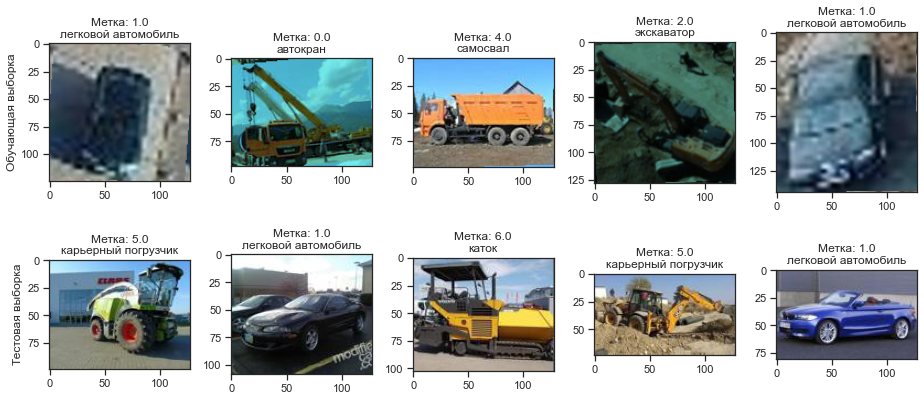

In [72]:
sns.set_theme(style="ticks")
classes = {0: 'автокран',
           1: 'легковой автомобиль',
           2: 'экскаватор',
           3: 'человек',
           4: 'самосвал',
           5: 'карьерный погрузчик',
           6: 'каток',
           7: 'бульдозер'}
fig, axes = plt.subplots(2, 5, figsize=(13, 6))

for idx, data in enumerate((ds.train_df, ds.val_df)):
    for jdx, kdx in enumerate(np.random.randint(0, len(data), size=5)):
        image, label = data['image'][kdx], data['class'][kdx]
        if idx == 0:
            image = ds.augmentation(image, label)
        axes[idx, jdx].imshow(Image.fromarray(image))
        axes[idx, jdx].set_title(f'Метка: {label}\n{classes[label]}')
        
axes[0, 0].set_ylabel('Обучающая выборка')
axes[1, 0].set_ylabel('Тестовая выборка')
        
fig.tight_layout()
plt.show()

In [15]:
ds.val_df['class'].value_counts().sort_index()

0.0     39
1.0    152
2.0     33
3.0     88
4.0     80
5.0     59
6.0     28
7.0     20
Name: class, dtype: int64

In [16]:
def compute_accuracy(conf_matrix, n_classes):
    acc = np.zeros(n_classes)
    for i in range(n_classes):
        tp_fn = np.sum(conf_matrix[i])
        if tp_fn == 0:
            acc[i] = 0.0
        else:
            acc[i] = conf_matrix[i, i] / tp_fn
    return acc

In [17]:
torch.cuda.memory_allocated(device=device)

0

In [18]:
model = ViTForImageClassification.from_pretrained(model_name_or_path, num_labels=8)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [73]:
set_seed(42)
n_classes = 8
epoch = 10
batch_size = 16

model.cpu()
del model

gc.collect()
torch.cuda.empty_cache()

model = ViTForImageClassification.from_pretrained(model_name_or_path, num_labels=n_classes)#, output_attentions=True
model.to(device)

loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
sheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)

        
train_loss = []
train_acc = []
val_loss = []
val_acc = []

pbar = tqdm.tqdm(range(epoch), total=epoch)

for _ in pbar:
    ds.set_split('train')
    dl = DataLoader(dataset=ds, batch_size=batch_size,
                    shuffle=True, drop_last=True)
    
    running_loss = 0.0
    running_confusion_matrix = np.zeros((n_classes, n_classes))
    model.train()

    for idx, batch in tqdm.tqdm(enumerate(dl), total=len(dl), leave=False):
        optimizer.zero_grad()
        
        outputs = model(batch['pixel_values'].to(device))
        loss = loss_func(outputs['logits'], batch['class'].to(device))
            
        loss_batch = loss.item()
        running_loss += (loss_batch - running_loss) / (idx + 1)
        
        preds = np.argmax(outputs['logits'].cpu().detach().numpy(), axis=1)
        running_confusion_matrix += confusion_matrix(batch['class'], preds,
                                                     labels=np.arange(n_classes))
        loss.backward()
        optimizer.step()
        
        outputs['logits'].cpu()
        del outputs
    sheduler.step()

    train_loss.append(running_loss)
    train_acc.append(compute_accuracy(running_confusion_matrix, n_classes))

    ds.set_split('val')
    dl = DataLoader(dataset=ds, batch_size=batch_size,
                    shuffle=False, drop_last=False)
    
    running_loss = 0.0
    running_confusion_matrix = np.zeros((n_classes, n_classes))
    model.eval()
    
    with torch.no_grad():

        for idx, batch in tqdm.tqdm(enumerate(dl), total=len(dl), leave=False):

            outputs = model(batch['pixel_values'].to(device))
            loss = loss_func(outputs['logits'], batch['class'].to(device))

            loss_batch = loss.item()
            running_loss += (loss_batch - running_loss) / (idx + 1)
            
            preds = np.argmax(outputs['logits'].cpu().detach().numpy(), axis=1)
            running_confusion_matrix += confusion_matrix(batch['class'], preds,
                                                         labels=np.arange(n_classes))
            outputs['logits'].cpu()
            del outputs

        val_loss.append(running_loss)
        val_acc.append(compute_accuracy(running_confusion_matrix, n_classes))
    
    print('Loss (Train/Test): {0:.3f}/{1:.3f}.\n\
    Classes recall (Train/Test): {2}/{3}.\n\
    Recall (Train/Test): {4:.3f}/{5:.3f}'.format(
        train_loss[-1], val_loss[-1], 
        np.round(train_acc[-1], 2), np.round(val_acc[-1], 2),
        np.mean(train_acc[-1]), np.mean(val_acc[-1])
    ))
    pbar.set_description(
                'Loss (Train/Test): {0:.3f}/{1:.3f}.\nRecall (Train/Test): {2:.3f}/{3:.3f}\n'.format(
                    train_loss[-1], val_loss[-1], np.mean(train_acc[-1]), np.mean(val_acc[-1])
                )
            )

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss (Train/Test): 0.294/0.151.
    Classes recall (Train/Test): [0.85 0.97 0.82 0.98 0.93 0.92 0.85 0.78]/[0.92 0.99 0.82 1.   1.   0.9  0.89 0.95].
    Recall (Train/Test): 0.887/0.934


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss (Train/Test): 0.079/0.074.
    Classes recall (Train/Test): [0.98 0.99 0.95 0.99 0.98 0.95 0.96 0.97]/[0.95 1.   0.94 0.98 0.99 0.98 0.96 1.  ].
    Recall (Train/Test): 0.970/0.975


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss (Train/Test): 0.028/0.083.
    Classes recall (Train/Test): [0.99 1.   0.98 1.   0.99 0.99 0.99 0.99]/[0.92 0.99 0.94 1.   0.99 0.97 0.89 1.  ].
    Recall (Train/Test): 0.991/0.963


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss (Train/Test): 0.023/0.044.
    Classes recall (Train/Test): [0.98 1.   0.99 1.   0.99 0.98 0.99 0.99]/[0.95 0.99 0.97 1.   1.   1.   0.93 1.  ].
    Recall (Train/Test): 0.991/0.980


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss (Train/Test): 0.007/0.048.
    Classes recall (Train/Test): [0.99 1.   0.99 1.   1.   1.   0.99 0.99]/[0.95 1.   0.97 0.99 1.   1.   0.96 1.  ].
    Recall (Train/Test): 0.996/0.984


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss (Train/Test): 0.005/0.050.
    Classes recall (Train/Test): [1.   1.   0.99 1.   1.   1.   1.   0.99]/[0.95 1.   0.97 1.   1.   0.98 0.96 1.  ].
    Recall (Train/Test): 0.998/0.983


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss (Train/Test): 0.003/0.049.
    Classes recall (Train/Test): [1.   1.   0.99 1.   1.   1.   1.   1.  ]/[0.95 1.   0.97 1.   1.   1.   0.96 1.  ].
    Recall (Train/Test): 0.999/0.985


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss (Train/Test): 0.002/0.041.
    Classes recall (Train/Test): [1. 1. 1. 1. 1. 1. 1. 1.]/[0.95 1.   0.97 1.   1.   1.   0.96 1.  ].
    Recall (Train/Test): 1.000/0.985


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss (Train/Test): 0.002/0.042.
    Classes recall (Train/Test): [1. 1. 1. 1. 1. 1. 1. 1.]/[0.95 1.   0.97 1.   1.   1.   0.96 1.  ].
    Recall (Train/Test): 1.000/0.985


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss (Train/Test): 0.002/0.042.
    Classes recall (Train/Test): [1. 1. 1. 1. 1. 1. 1. 1.]/[0.95 1.   0.97 1.   1.   1.   0.96 1.  ].
    Recall (Train/Test): 1.000/0.985


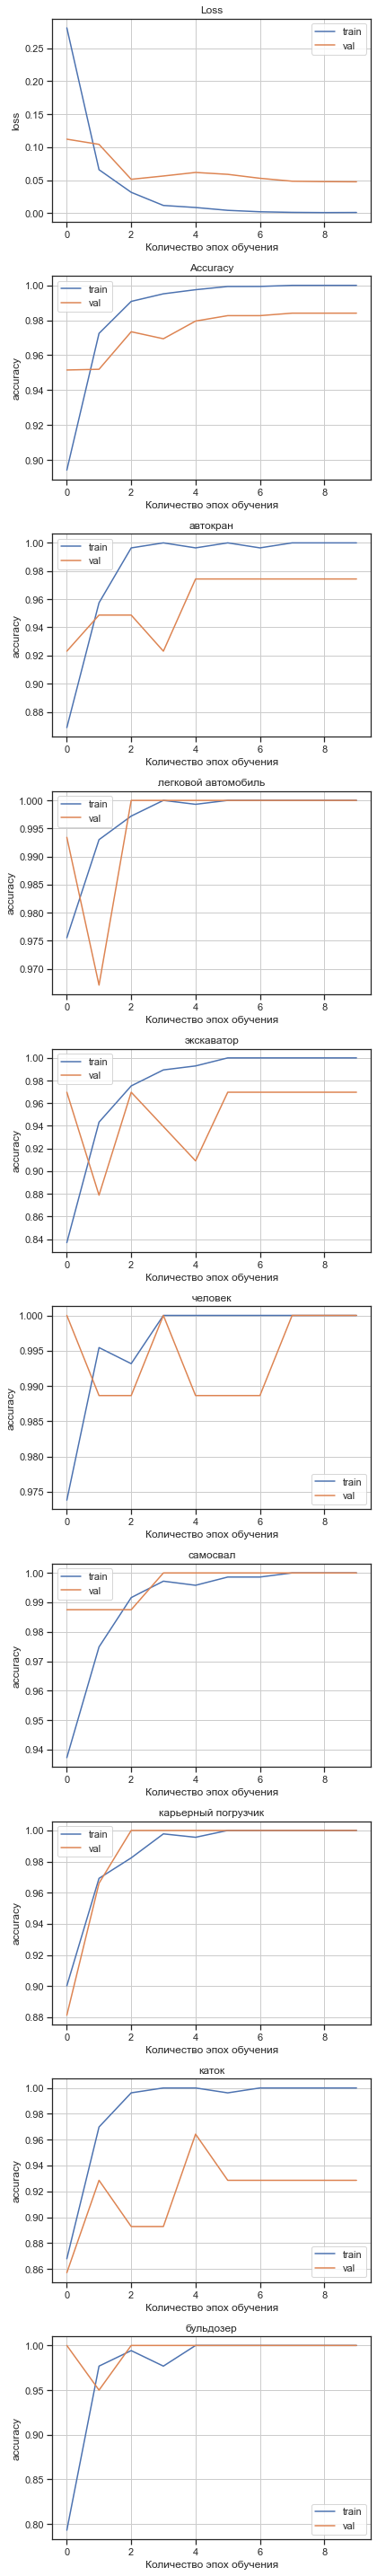

In [46]:
train_acc = np.array(train_acc)
val_acc = np.array(val_acc)
mean_train_acc = np.mean(train_acc, axis=1)
mean_val_acc = np.mean(val_acc, axis=1)

fig, ax = plt.subplots(10, 1, figsize=(6, 40), )

ax[0].plot(np.arange(len(train_loss)), train_loss, label='train')
ax[0].plot(np.arange(len(val_loss)), val_loss, label='val')
ax[0].set_xlabel('Количество эпох обучения')
ax[0].set_ylabel('loss')
ax[0].set_title('Loss')
ax[0].legend()
ax[0].grid(True)

ax[1].plot(np.arange(len(mean_train_acc)), mean_train_acc, label='train')
ax[1].plot(np.arange(len(mean_val_acc)), mean_val_acc, label='val')
ax[1].set_xlabel('Количество эпох обучения')
ax[1].set_ylabel('accuracy')
ax[1].set_title('Accuracy')
ax[1].legend()
ax[1].grid(True)

for i in range(n_classes):
    ax[i + 2].plot(np.arange(len(train_acc[:, i])), train_acc[:, i], label='train')
    ax[i + 2].plot(np.arange(len(val_acc[:, i])), val_acc[:, i], label='val')
    ax[i + 2].set_xlabel('Количество эпох обучения')
    ax[i + 2].set_ylabel('accuracy')
    ax[i + 2].set_title(classes[i])
    ax[i + 2].legend()
    ax[i + 2].grid(True)

fig.tight_layout()
plt.show()

In [47]:
mean_val_acc[-1]

0.9840784215784216

In [47]:
LR = [(11e-3, 1e-3), (11e-3, 1e-4), (11e-3, 1e-5), (11e-3, 1e-6)]
n = 12

for idx_lr, lr in enumerate(LR):
    base_lr, min_lr = lr
    
    set_seed(42)
    n_classes = 8
    epoch = 10
    batch_size = 16

    model.cpu()
    del model

    gc.collect()
    torch.cuda.empty_cache()

    model = ViTForImageClassification.from_pretrained(model_name_or_path, num_labels=n_classes)#, output_attentions=True
    model.to(device)

    loss_func = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=base_lr, momentum=0.9)
    sheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=min_lr)


    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []

    pbar = tqdm.tqdm(range(epoch), total=epoch)

    for _ in pbar:
        ds.set_split('train')
        dl = DataLoader(dataset=ds, batch_size=batch_size,
                        shuffle=True, drop_last=True)

        running_loss = 0.0
        running_confusion_matrix = np.zeros((n_classes, n_classes))
        model.train()

        for idx, batch in tqdm.tqdm(enumerate(dl), total=len(dl), leave=False):
            optimizer.zero_grad()

            outputs = model(batch['pixel_values'].to(device))
            loss = loss_func(outputs['logits'], batch['class'].to(device))

            loss_batch = loss.item()
            running_loss += (loss_batch - running_loss) / (idx + 1)

            preds = np.argmax(outputs['logits'].cpu().detach().numpy(), axis=1)
            running_confusion_matrix += confusion_matrix(batch['class'], preds,
                                                         labels=np.arange(n_classes))
            loss.backward()
            optimizer.step()

            outputs['logits'].cpu()
            del outputs
        sheduler.step()

        train_loss.append(running_loss)
        train_acc.append(compute_accuracy(running_confusion_matrix, n_classes))

        ds.set_split('val')
        dl = DataLoader(dataset=ds, batch_size=batch_size,
                        shuffle=False, drop_last=False)

        running_loss = 0.0
        running_confusion_matrix = np.zeros((n_classes, n_classes))
        model.eval()

        with torch.no_grad():

            for idx, batch in tqdm.tqdm(enumerate(dl), total=len(dl), leave=False):

                outputs = model(batch['pixel_values'].to(device))
                loss = loss_func(outputs['logits'], batch['class'].to(device))

                loss_batch = loss.item()
                running_loss += (loss_batch - running_loss) / (idx + 1)

                preds = np.argmax(outputs['logits'].cpu().detach().numpy(), axis=1)
                running_confusion_matrix += confusion_matrix(batch['class'], preds,
                                                             labels=np.arange(n_classes))
                outputs['logits'].cpu()
                del outputs

            val_loss.append(running_loss)
            val_acc.append(compute_accuracy(running_confusion_matrix, n_classes))

        print('Loss (Train/Test): {0:.3f}/{1:.3f}.\n\
        Classes recall (Train/Test): {2}/{3}.\n\
        Recall (Train/Test): {4:.3f}/{5:.3f}'.format(
            train_loss[-1], val_loss[-1], 
            np.round(train_acc[-1], 2), np.round(val_acc[-1], 2),
            np.mean(train_acc[-1]), np.mean(val_acc[-1])
        ))
        pbar.set_description(
                    'Loss (Train/Test): {0:.3f}/{1:.3f}.\nRecall (Train/Test): {2:.3f}/{3:.3f}\n'.format(
                        train_loss[-1], val_loss[-1], np.mean(train_acc[-1]), np.mean(val_acc[-1])
                    )
                )
    np.save('train_loss_lr_{}.npy'.format(idx_lr + n), train_loss)
    np.save('train_acc_lr_{}.npy'.format(idx_lr + n), train_acc)
    np.save('val_loss_lr_{}.npy'.format(idx_lr + n), val_loss)
    np.save('val_acc_lr_{}.npy'.format(idx_lr + n), val_acc)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss (Train/Test): 0.298/0.254.
        Classes recall (Train/Test): [0.85 0.97 0.79 0.97 0.93 0.89 0.87 0.8 ]/[0.74 0.94 0.97 0.97 0.99 0.83 0.93 0.9 ].
        Recall (Train/Test): 0.884/0.908


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss (Train/Test): 0.055/0.064.
        Classes recall (Train/Test): [0.97 1.   0.95 0.99 0.98 0.97 0.99 0.98]/[0.95 1.   0.97 1.   0.99 0.93 0.96 0.95].
        Recall (Train/Test): 0.980/0.969


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss (Train/Test): 0.030/0.077.
        Classes recall (Train/Test): [0.99 1.   0.97 1.   0.99 0.98 0.99 0.97]/[0.95 0.99 0.91 1.   0.96 1.   0.96 0.95].
        Recall (Train/Test): 0.987/0.966


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss (Train/Test): 0.015/0.074.
        Classes recall (Train/Test): [1.   1.   0.98 1.   0.99 0.99 1.   0.99]/[0.92 0.99 0.97 0.99 1.   0.98 0.96 0.9 ].
        Recall (Train/Test): 0.994/0.965


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss (Train/Test): 0.006/0.063.
        Classes recall (Train/Test): [1.   1.   1.   1.   1.   1.   0.99 1.  ]/[0.97 1.   0.97 1.   1.   0.93 0.96 1.  ].
        Recall (Train/Test): 0.998/0.980


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss (Train/Test): 0.003/0.072.
        Classes recall (Train/Test): [1. 1. 1. 1. 1. 1. 1. 1.]/[0.95 1.   0.97 1.   1.   0.98 0.89 1.  ].
        Recall (Train/Test): 1.000/0.974


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss (Train/Test): 0.003/0.044.
        Classes recall (Train/Test): [1. 1. 1. 1. 1. 1. 1. 1.]/[0.95 1.   0.97 1.   1.   0.98 0.96 1.  ].
        Recall (Train/Test): 1.000/0.983


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss (Train/Test): 0.001/0.043.
        Classes recall (Train/Test): [1. 1. 1. 1. 1. 1. 1. 1.]/[0.95 1.   0.97 1.   1.   0.98 0.96 1.  ].
        Recall (Train/Test): 1.000/0.983


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss (Train/Test): 0.001/0.044.
        Classes recall (Train/Test): [1. 1. 1. 1. 1. 1. 1. 1.]/[0.95 1.   0.97 1.   1.   0.98 0.96 1.  ].
        Recall (Train/Test): 1.000/0.983


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss (Train/Test): 0.001/0.044.
        Classes recall (Train/Test): [1. 1. 1. 1. 1. 1. 1. 1.]/[0.95 1.   0.97 1.   1.   0.98 0.96 1.  ].
        Recall (Train/Test): 1.000/0.983


Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss (Train/Test): 0.298/0.254.
        Classes recall (Train/Test): [0.85 0.97 0.79 0.97 0.93 0.89 0.87 0.8 ]/[0.74 0.94 0.97 0.97 0.99 0.83 0.93 0.9 ].
        Recall (Train/Test): 0.884/0.908


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss (Train/Test): 0.062/0.089.
        Classes recall (Train/Test): [0.96 0.99 0.94 1.   0.98 0.97 0.96 0.97]/[0.92 1.   0.94 1.   1.   0.9  0.96 0.95].
        Recall (Train/Test): 0.972/0.959


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss (Train/Test): 0.028/0.130.
        Classes recall (Train/Test): [0.99 1.   0.98 1.   0.99 0.98 0.98 0.97]/[0.9  0.99 0.88 1.   1.   0.98 0.96 0.8 ].
        Recall (Train/Test): 0.985/0.940


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss (Train/Test): 0.025/0.071.
        Classes recall (Train/Test): [0.99 1.   0.97 1.   1.   0.99 0.99 0.98]/[0.9  0.99 0.94 1.   1.   1.   0.96 1.  ].
        Recall (Train/Test): 0.988/0.973


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss (Train/Test): 0.011/0.065.
        Classes recall (Train/Test): [1.   1.   0.99 1.   0.99 1.   1.   1.  ]/[0.97 0.99 0.97 0.99 1.   1.   0.89 1.  ].
        Recall (Train/Test): 0.996/0.977


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss (Train/Test): 0.009/0.049.
        Classes recall (Train/Test): [1.   1.   0.99 1.   1.   1.   1.   0.99]/[0.97 1.   0.97 1.   1.   0.97 0.96 1.  ].
        Recall (Train/Test): 0.995/0.984


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss (Train/Test): 0.001/0.039.
        Classes recall (Train/Test): [1. 1. 1. 1. 1. 1. 1. 1.]/[0.97 1.   0.97 1.   1.   1.   0.96 1.  ].
        Recall (Train/Test): 1.000/0.989


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss (Train/Test): 0.001/0.038.
        Classes recall (Train/Test): [1. 1. 1. 1. 1. 1. 1. 1.]/[0.97 1.   0.97 1.   1.   1.   0.96 1.  ].
        Recall (Train/Test): 1.000/0.989


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss (Train/Test): 0.001/0.040.
        Classes recall (Train/Test): [1. 1. 1. 1. 1. 1. 1. 1.]/[0.97 1.   0.97 1.   1.   1.   0.96 1.  ].
        Recall (Train/Test): 1.000/0.989


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss (Train/Test): 0.001/0.040.
        Classes recall (Train/Test): [1. 1. 1. 1. 1. 1. 1. 1.]/[0.97 1.   0.97 1.   1.   1.   0.96 1.  ].
        Recall (Train/Test): 1.000/0.989


Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss (Train/Test): 0.298/0.254.
        Classes recall (Train/Test): [0.85 0.97 0.79 0.97 0.93 0.89 0.87 0.8 ]/[0.74 0.94 0.97 0.97 0.99 0.83 0.93 0.9 ].
        Recall (Train/Test): 0.884/0.908


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss (Train/Test): 0.059/0.099.
        Classes recall (Train/Test): [0.97 1.   0.95 1.   0.98 0.96 0.97 0.97]/[0.97 0.97 0.97 1.   0.99 0.93 0.96 0.95].
        Recall (Train/Test): 0.974/0.969


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss (Train/Test): 0.034/0.095.
        Classes recall (Train/Test): [0.98 1.   0.97 1.   0.99 0.99 0.98 0.99]/[0.92 1.   0.91 0.99 1.   0.97 0.96 0.95].
        Recall (Train/Test): 0.986/0.963


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss (Train/Test): 0.010/0.056.
        Classes recall (Train/Test): [1.   1.   0.99 1.   1.   1.   1.   0.98]/[0.95 1.   0.97 1.   1.   1.   0.96 1.  ].
        Recall (Train/Test): 0.996/0.985


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss (Train/Test): 0.004/0.053.
        Classes recall (Train/Test): [1.   1.   0.99 1.   1.   1.   1.   1.  ]/[0.97 1.   0.97 1.   0.99 1.   0.93 1.  ].
        Recall (Train/Test): 0.999/0.983


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss (Train/Test): 0.002/0.046.
        Classes recall (Train/Test): [1. 1. 1. 1. 1. 1. 1. 1.]/[0.97 1.   0.97 1.   1.   1.   0.96 1.  ].
        Recall (Train/Test): 1.000/0.989


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss (Train/Test): 0.002/0.047.
        Classes recall (Train/Test): [1. 1. 1. 1. 1. 1. 1. 1.]/[0.97 1.   0.97 1.   0.99 1.   0.96 1.  ].
        Recall (Train/Test): 1.000/0.987


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss (Train/Test): 0.002/0.049.
        Classes recall (Train/Test): [1. 1. 1. 1. 1. 1. 1. 1.]/[0.95 1.   0.97 1.   1.   1.   0.96 1.  ].
        Recall (Train/Test): 1.000/0.985


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss (Train/Test): 0.002/0.047.
        Classes recall (Train/Test): [1.   1.   0.99 1.   1.   1.   1.   1.  ]/[0.95 1.   0.97 1.   1.   1.   0.96 1.  ].
        Recall (Train/Test): 0.999/0.985


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss (Train/Test): 0.001/0.047.
        Classes recall (Train/Test): [1. 1. 1. 1. 1. 1. 1. 1.]/[0.95 1.   0.97 1.   1.   1.   0.96 1.  ].
        Recall (Train/Test): 1.000/0.985


Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss (Train/Test): 0.298/0.254.
        Classes recall (Train/Test): [0.85 0.97 0.79 0.97 0.93 0.89 0.87 0.8 ]/[0.74 0.94 0.97 0.97 0.99 0.83 0.93 0.9 ].
        Recall (Train/Test): 0.884/0.908


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss (Train/Test): 0.067/0.109.
        Classes recall (Train/Test): [0.97 0.99 0.96 0.99 0.98 0.96 0.98 0.97]/[0.92 0.99 0.91 0.99 1.   0.97 0.96 0.85].
        Recall (Train/Test): 0.975/0.949


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss (Train/Test): 0.035/0.083.
        Classes recall (Train/Test): [0.99 1.   0.97 1.   0.99 0.97 0.97 0.98]/[0.9  1.   0.97 0.99 0.98 1.   0.96 0.95].
        Recall (Train/Test): 0.984/0.968


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss (Train/Test): 0.013/0.057.
        Classes recall (Train/Test): [0.99 1.   0.98 1.   1.   1.   1.   0.99]/[0.92 0.99 0.97 1.   1.   1.   0.96 1.  ].
        Recall (Train/Test): 0.995/0.981


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss (Train/Test): 0.004/0.053.
        Classes recall (Train/Test): [1. 1. 1. 1. 1. 1. 1. 1.]/[0.95 1.   0.97 1.   0.99 1.   0.96 1.  ].
        Recall (Train/Test): 0.999/0.984


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss (Train/Test): 0.002/0.058.
        Classes recall (Train/Test): [1. 1. 1. 1. 1. 1. 1. 1.]/[0.95 1.   0.97 1.   1.   1.   0.96 0.95].
        Recall (Train/Test): 1.000/0.979


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss (Train/Test): 0.001/0.055.
        Classes recall (Train/Test): [1. 1. 1. 1. 1. 1. 1. 1.]/[0.95 1.   0.97 1.   1.   1.   0.96 1.  ].
        Recall (Train/Test): 1.000/0.985


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss (Train/Test): 0.001/0.052.
        Classes recall (Train/Test): [1. 1. 1. 1. 1. 1. 1. 1.]/[0.95 1.   0.97 1.   1.   1.   0.96 1.  ].
        Recall (Train/Test): 1.000/0.985


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss (Train/Test): 0.001/0.052.
        Classes recall (Train/Test): [1. 1. 1. 1. 1. 1. 1. 1.]/[0.95 1.   0.97 1.   1.   1.   0.96 1.  ].
        Recall (Train/Test): 1.000/0.985


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss (Train/Test): 0.001/0.052.
        Classes recall (Train/Test): [1. 1. 1. 1. 1. 1. 1. 1.]/[0.95 1.   0.97 1.   1.   1.   0.96 1.  ].
        Recall (Train/Test): 1.000/0.985


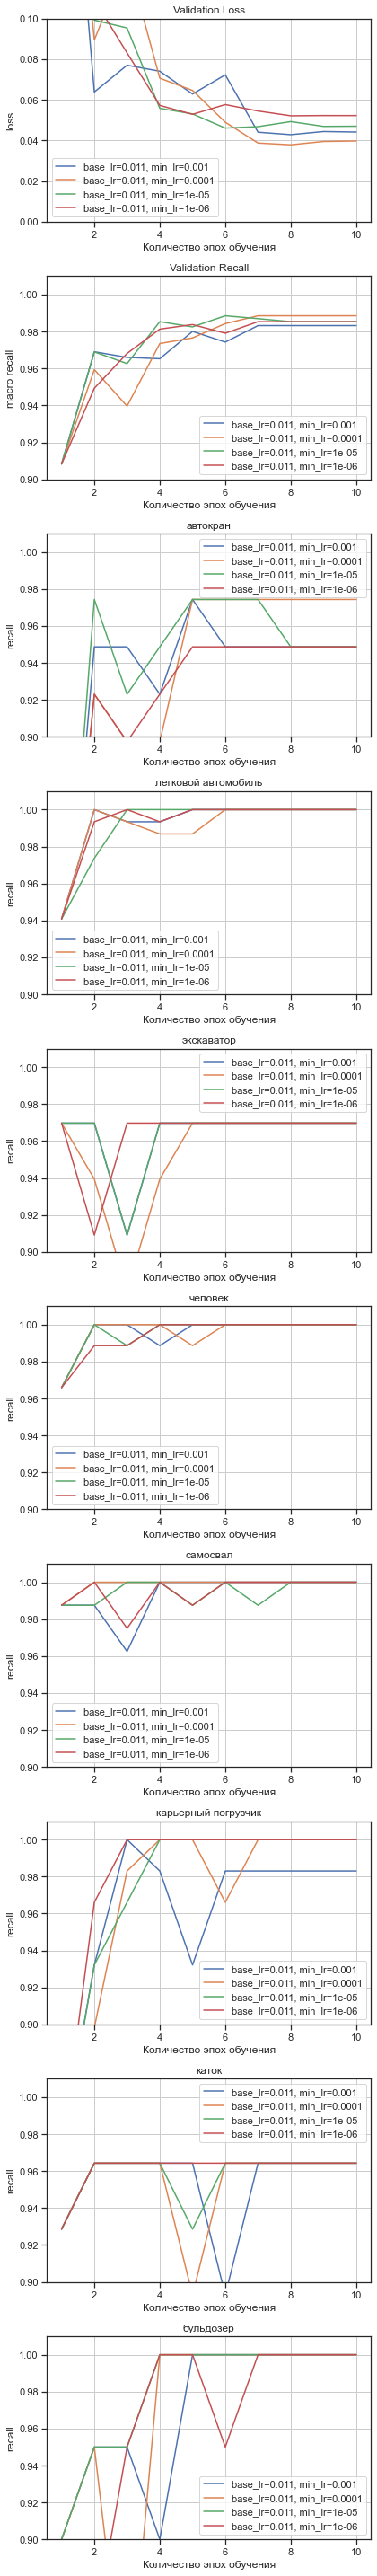

In [49]:
n = 12
fig, ax = plt.subplots(10, 1, figsize=(6, 40), )
for i in range(4):
    base_lr, min_lr = LR[i]
    ax[0].plot(np.arange(1, 11), np.load('val_loss_lr_{}.npy'.format(i + n)), 
               label='base_lr={}, min_lr={}'.format(base_lr, min_lr))
ax[0].set_xlabel('Количество эпох обучения')
ax[0].set_ylabel('loss')
ax[0].set_ylim(bottom=0.0, top=0.1)
ax[0].set_title('Validation Loss')
ax[0].legend()
ax[0].grid(True)

for i in range(4):
    base_lr, min_lr = LR[i]
    val_acc = np.load('val_acc_lr_{}.npy'.format(i + n))
    ax[1].plot(np.arange(1, 11), np.mean(val_acc, axis=1), 
               label='base_lr={}, min_lr={}'.format(base_lr, min_lr))
    for j in range(n_classes):
        ax[j + 2].plot(np.arange(1, 11), val_acc[:, j], 
                       label='base_lr={}, min_lr={}'.format(base_lr, min_lr))
    
ax[1].set_xlabel('Количество эпох обучения')
ax[1].set_ylabel('macro recall')
ax[1].set_title('Validation Recall')
ax[1].set_ylim(bottom=0.9, top=1.01)
ax[1].legend()
ax[1].grid(True)

for i in range(n_classes):
    ax[i + 2].set_xlabel('Количество эпох обучения')
    ax[i + 2].set_ylabel('recall')
    ax[i + 2].set_ylim(bottom=0.9, top=1.01)
    ax[i + 2].set_title(classes[i])
    ax[i + 2].legend()
    ax[i + 2].grid(True)

fig.tight_layout()
plt.show()

In [74]:
running_confusion_matrix

array([[ 37.,   0.,   0.,   0.,   1.,   1.,   0.,   0.],
       [  0., 152.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,  32.,   0.,   0.,   1.,   0.,   0.],
       [  0.,   0.,   0.,  88.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,  80.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,  59.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,  27.,   1.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,  20.]])

In [75]:
preds = np.array([])

model.eval()

ds.set_split('test')
dl = DataLoader(dataset=ds, batch_size=batch_size, shuffle=False, drop_last=False)
    
with torch.no_grad():

    for idx, batch in tqdm.tqdm(enumerate(dl), total=len(dl)):

        outputs = model(batch['pixel_values'].to(device))
            
        preds_batch = np.argmax(outputs['logits'].cpu().detach().numpy(), axis=1)
        preds = np.concatenate((preds, preds_batch), axis=None)
        
        for name, elem in outputs.items():
            elem.cpu()
        del outputs

  0%|          | 0/134 [00:00<?, ?it/s]

In [76]:
preds.shape

(2138,)

In [77]:
df_test = df_test.drop(["class"], axis = 1)
df_test["class"] = preds
df_test.head()

,ID_img,class
0,0.jpg,5.0
1,1.jpg,5.0
2,2.jpg,1.0
3,3.jpg,1.0
4,4.jpg,6.0


In [82]:
df_test.to_csv("submit5.csv", index=False)

## Вспомогательные функции

In [187]:
import cv2

def get_attention_map(img, get_mask=True):
    x = feature_extractor(img, return_tensors='pt')['pixel_values']
    #x.size()

    outputs = model(x.to(device))
    logits, att_mat = outputs['logits'].cpu(), outputs['attentions']

    att_mat = torch.stack(att_mat).squeeze(1)

    # Average the attention weights across all heads.
    att_mat = torch.mean(att_mat, dim=1)

    # To account for residual connections, we add an identity matrix to the
    # attention matrix and re-normalize the weights.
    residual_att = torch.eye(att_mat.size(1)).to(device)
    aug_att_mat = att_mat + residual_att
    aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

    # Recursively multiply the weight matrices
    joint_attentions = torch.zeros(aug_att_mat.size())
    joint_attentions[0] = aug_att_mat[0]

    for n in range(1, aug_att_mat.size(0)):
        joint_attentions[n] = torch.matmul(aug_att_mat[n].cpu(), joint_attentions[n-1])

    v = joint_attentions[-1]
    grid_size = int(np.sqrt(aug_att_mat.size(-1)))
    mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
    if get_mask:
        result = cv2.resize(mask / mask.max(), img.size)
    else:        
        mask = cv2.resize(mask / mask.max(), img.size)[..., np.newaxis]
        result = (mask * img).astype("uint8")
    
    return result

def plot_attention_map(original_img, att_map):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))
    ax1.set_title('Original')
    ax2.set_title('Attention Map Last Layer')
    _ = ax1.imshow(original_img)
    _ = ax2.imshow(att_map)

In [198]:
i = 3
img = Image.fromarray(ds.val_df['image'][i])
ds.val_df['class'][i]

6.0

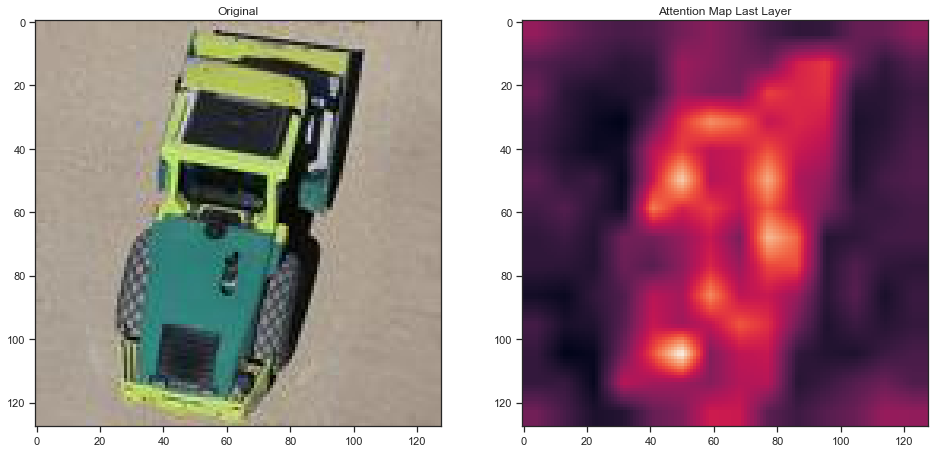

In [199]:
result1 = get_attention_map(img)
plot_attention_map(img, result1)

Если надо почистить память

In [ ]:
import gc

gc.collect()

In [ ]:
torch.cuda.empty_cache()